In [1]:
import torch
torch.cuda.empty_cache()

<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Angelika Vergara\AppData\Local\Temp\ipykernel_14212\3131528818.py:67: SyntaxWarning: invalid escape sequence '\s'
  df['text'] = df['text'].str.lower().str.replace('[^a-zA-Z\s]', '', regex=True)


Using device: cuda
Using Davidson Hate Speech and Offensive Language dataset


c:\Users\Angelika Vergara\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
c:\Users\Angelika Vergara\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.3883
Epoch 1, Val Accuracy: 0.9165
Epoch 2, Loss: 0.1994
Epoch 2, Val Accuracy: 0.9383
Epoch 3, Loss: 0.1760
Epoch 3, Val Accuracy: 0.9347
Early stopping counter: 1
Epoch 4, Loss: 0.1581
Epoch 4, Val Accuracy: 0.9407
Epoch 5, Loss: 0.1454
Epoch 5, Val Accuracy: 0.9512
Epoch 6, Loss: 0.1358
Epoch 6, Val Accuracy: 0.9524
Epoch 7, Loss: 0.1276
Epoch 7, Val Accuracy: 0.9568
Epoch 8, Loss: 0.1213
Epoch 8, Val Accuracy: 0.9576
Average forward pass time: 0.1211 seconds

Final Validation Metrics (on best model):
Accuracy: 0.9576
Precision: 0.9832
Recall: 0.9656
F1-score: 0.9743

Classification Report (on best model):
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       416
           1       0.98      0.97      0.97      2063

    accuracy                           0.96      2479
   macro avg       0.91      0.94      0.93      2479
weighted avg       0.96      0.96      0.96      2479



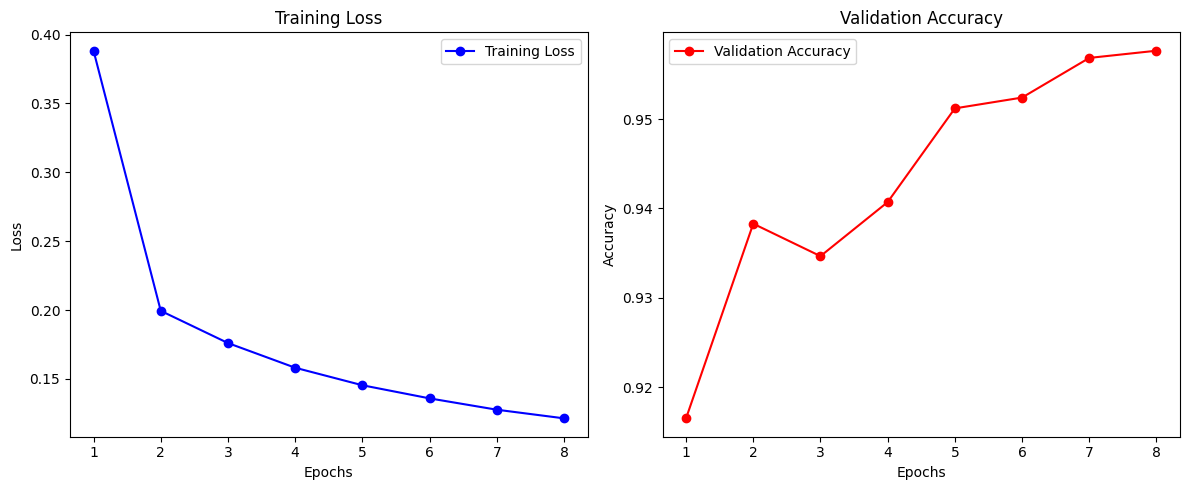

In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.utils import class_weight

# Configuration
CONFIG = {
    "max_len": 256,
    "batch_size": 128,
    "lstm_hidden_dim": 384,
    "num_lstm_layers": 2,
    "dropout_rate": 0.5,  # Increased dropout rate (more aggressive)
    "learning_rate": 1e-5,
    "weight_decay": 0.015,  # Increased weight decay
    "patience": 3,  # Adjusted patience
    "min_delta": 0.0005,  # Adjusted min_delta
    "num_epochs": 8,  # Reduced max epochs, relying more on early stopping
    "gradient_accumulation_steps": 2,
    "lstm_dropout_rate": 0.3, # Dropout rate for LSTM layers
    "davidson_data_url": "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/refs/heads/master/data/labeled_data.csv",
    "kaggle_data_url": "https://www.kaggle.com/datasets/akashsuper2000/toxic-comment-classification?select=train.csv",
    "use_kaggle_data": False #Toggle True/False to switch datasets
}

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess data function
def load_and_preprocess_data(davidson_data_url, kaggle_data_url, use_kaggle_data):
    if use_kaggle_data:
        print("Using Kaggle Toxic Comment Classification dataset")
        try:
            df = pd.read_csv(kaggle_data_url)
            #df = df.sample(n=10000)  # Subsample for testing
            df = df[['comment_text', 'toxic']]
            df.rename(columns={'comment_text': 'text', 'toxic': 'label'}, inplace=True)
            df = df[df['label'].isin([0, 1])]
        except Exception as e:
            print(f"Error loading Kaggle data: {e}")
            return None, None
    else:
        print("Using Davidson Hate Speech and Offensive Language dataset")
        try:
            df = pd.read_csv(davidson_data_url)
            df = df[['tweet', 'class']]
            df.rename(columns={'tweet': 'text', 'class': 'label'}, inplace=True)
            # Map class labels: 0 (hate speech), 1 (offensive language), 2 (neither)
            df['label'] = df['label'].map({0: 1, 1: 1, 2: 0})
            df = df[df['label'].isin([0, 1])] #Only use labels 0 and 1
            #df = df.sample(n=10000)  # Subsample for testing
        except Exception as e:
            print(f"Error loading Davidson data: {e}")
            return None, None

    # Basic cleaning (lowercase and remove special characters)
    df['text'] = df['text'].str.lower().str.replace('[^a-zA-Z\s]', '', regex=True)
    return train_test_split(df['text'].tolist(), df['label'].tolist(), test_size=0.1, random_state=42, stratify=df['label'])

# Load the data
train_texts, val_texts, train_labels, val_labels = load_and_preprocess_data(
    CONFIG["davidson_data_url"],
    CONFIG["kaggle_data_url"],
    CONFIG["use_kaggle_data"]
)

# Check if the data loading was successful
if train_texts is None or val_texts is None:
    print("Failed to load data. Exiting.")
    exit()

identity_terms = ["muslim", "black", "women", "democrat", "hispanics", "latinos"]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128
# No need for custom word_to_index dictionary with BERT

def pad_sequence(sequence, max_length, pad_token_id):
    return sequence + [pad_token_id] * (max_length - len(sequence))

class ToxicCommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, identity_terms):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.identity_terms = identity_terms

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        subjectivity_score = TextBlob(text).sentiment.subjectivity
        identity_term_present = 1 if any(term in text.lower() for term in self.identity_terms) else 0

        # Use BERT tokenizer directly
        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoded_text['input_ids'].flatten()
        attention_mask = encoded_text['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'subjectivity_score': torch.tensor(subjectivity_score, dtype=torch.float),
            'identity_term_present': torch.tensor(identity_term_present, dtype=torch.float),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Data preparation
train_dataset = ToxicCommentDataset(train_texts, train_labels, tokenizer, max_len, identity_terms)
val_dataset = ToxicCommentDataset(val_texts, val_labels, tokenizer, max_len, identity_terms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Model with BERT and Attention Mechanism
class HybridModel(nn.Module):
    def __init__(self, lstm_hidden_dim=256, num_lstm_layers=1, dropout_rate=0.5, lstm_dropout_rate=0.3):  # Increased dropout
        super(HybridModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Unfreeze the last two layers of BERT - KEY IMPROVEMENT
        for name, param in self.bert.named_parameters():
            if 'encoder.layer.11' in name or 'encoder.layer.10' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.lstm = nn.LSTM(self.bert.config.hidden_size, lstm_hidden_dim, num_layers=num_lstm_layers,
                            batch_first=True, bidirectional=True, dropout=lstm_dropout_rate) # Separate dropout for LSTM
        self.dropout = nn.Dropout(dropout_rate) # Dropout after BERT
        self.attention_layer = nn.Linear(lstm_hidden_dim * 2, 1)
        self.classifier = nn.Linear(lstm_hidden_dim * 2 + 2, 2)

    def forward(self, input_ids, attention_mask=None,
                subjectivity_score=None,
                identity_term_present=None):

        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        lstm_input = bert_output.last_hidden_state  # Use the last hidden state as input to LSTM

        lstm_out, _ = self.lstm(lstm_input)

        attention_weights = torch.softmax(self.attention_layer(lstm_out).squeeze(-1), dim=-1)
        attended_lstm = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)

        pooled_output = self.dropout(attended_lstm)
        pooled_output = torch.cat((pooled_output, subjectivity_score.unsqueeze(1),
                                  identity_term_present.unsqueeze(1)), dim=1)
        return self.classifier(pooled_output)

# Early Stopping
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0001):  # Reduced patience
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_accuracy = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_accuracy is None:
            self.best_accuracy = val_accuracy
        elif val_accuracy < self.best_accuracy + self.min_delta:
            self.counter += 1
            print(f"Early stopping counter: {self.counter}")
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_accuracy = val_accuracy
            self.counter = 0

# Time Complexity Measurement
def measure_model_time_complexity(model, input_shape, device):
    model.eval()  # Set the model to evaluation mode
    input_ids = torch.randint(1, 1000, input_shape).to(device)  # Generate random input
    attention_mask = torch.ones(input_shape, dtype=torch.long).to(device)
    subjectivity_score = torch.randn(input_shape[0]).to(device)
    identity_term_present = torch.randint(0, 2, (input_shape[0],)).float().to(device)

    start_time = time.time()
    with torch.no_grad():  # Disable gradient calculation
        model(input_ids, attention_mask=attention_mask, subjectivity_score=subjectivity_score,
              identity_term_present=identity_term_present)
    end_time = time.time()

    return end_time - start_time

# Calculate class weights BEFORE the training loop, using train_labels from the split
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Model and Optimizer
model = HybridModel().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)  # Added scheduler
early_stopper = EarlyStopper(patience=CONFIG["patience"], min_delta=CONFIG["min_delta"])

# Training loop
train_losses = []
val_accuracies = []
best_model_state = None
best_accuracy = 0.0

for epoch in range(CONFIG["num_epochs"]):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}, Val Accuracy: {accuracy:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict()

    scheduler.step(accuracy)  # Scheduler step
    early_stopper(accuracy)
    if early_stopper.early_stop:
        print("Early stopping at epoch", epoch+1)
        break

# Measure model time complexity
input_shape = (64, max_len)  # Adjust batch size as needed
time_complexity = measure_model_time_complexity(model, input_shape, device)
print(f"Average forward pass time: {time_complexity:.4f} seconds")

# Final evaluation on best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\nFinal Validation Metrics (on best model):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification Report (on best model):")
    print(classification_report(all_labels, all_preds))

# Plotting
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

if val_loader:
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range[:len(val_accuracies)], val_accuracies, 'r-o', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [3]:
# Load best model state if it exists and save
if 'best_model_state' in locals() and best_model_state is not None:
    torch.save(best_model_state, 'toxic_comment_model_basedataset.pth')
    print("Best model saved to toxic_comment_model.pth")
else:
    print("No best model state found to save.")


Best model saved to toxic_comment_model.pth
